In [11]:
import snap
import sys, os
from collections import defaultdict
import itertools
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Constants

In [3]:
comment_dir = 'data/comments/'

subreddit_name_file = 'data/subredditIdToName'
filtered_users_file = 'data/filteredUsers'
user_node_ids_file = 'data/user_node_ids.npy'
subreddit_node_ids_file = 'data/subreddit_node_ids.npy'

comment_graph_file = 'data/comment_graph.txt'
current_comment_graph_file = 'data/current_comment_graph.txt'

## Load Data Structures

In [4]:
##############################################
# Load Raw Reddit Data
##############################################
def read_subreddit_names(filename):
    """
    Reads in file with global mappings from subreddit ids to names.
    Filters out subreddit names that begin with 'u_'.

    Examples: [subreddit_id subreddit_name]
        ...
        t5_3m6wn hormuz
        t5_bx9mz u_Ubiver
        ...

    Returns a dictionary mapping from id to name and a set of
    unique subreddit ids.
    """
    subreddit_name_dict = {} # id -> subreddit
    with open(filename) as f:
        for line in f:
            subreddit_id, subreddit_name = line.split()
            if subreddit_name.startswith('u_'): # not subreddit!
                continue
            subreddit_name_dict[subreddit_id] = subreddit_name
    return subreddit_name_dict

def read_filtered_users(filename):
    """
    """
    filtered_users = set() 
    with open(filename) as f:
        for line in f:
            user = line.strip()
            filtered_users.add(user)
    return filtered_users

def read_subreddit_comments(dirname, subreddit_name_dict, filtered_users=None, target_months=None):
    """
    Reads in files containing user-subreddit commenting counts. Each file
    name is of the format RC_YYYY-MM where YYYY and MM are year and month,
    respectively.

    Examples: [user subreddit_id comment_count]
        ...
        PGHContrarian68 t5_2ve45 4
        TheIncompetenceOfMan t5_2qh33 11
        ...

    Each edge is represented as (user, subreddit_id) and is weighted by
    the cumulative number of comments by the user on the subreddit.
    Note we only consider edges with existing subreddit_ids.

    Returns dictionary containing edges weighted by comments and
    and a set of unique users.
    """
    # Nodes
    users = set() # unique users 
    subreddits_ids = set() # unique subreddit ids
    
    # Edge set and weights
    comment_edges = set() # unique comment (user, subreddit_id) edges
    comment_weights = defaultdict(int) # edge (user, subreddit_id) -> comment_count
    
    # Edge dictionaries
    user_subreddit_dict = defaultdict(set) # user -> set(subreddit_ids)
    subreddit_user_dict = defaultdict(set) # subreddit_id -> set(users)
    
    for foldername, subdirlist, filelist in os.walk(dirname, topdown=False):
        for fname in sorted(filelist):
            if fname.startswith('RC_'): # formated as RC_YYYY-MM
                # Parse filename for date information
                _, yyyymm = fname.split('_')
                yyyy, mm = yyyymm.split('-')
                                
                # Only parse target months
                if mm not in target_months:
                    continue
                    
                month_users = set()
                month_subreddit_ids = set()
                month_comment_edges = set()

                # Parse the file for edge weights
                with open(os.path.join(dirname, fname)) as f:
                    for line in f:
                        user, subreddit_id, comment_count = line.split() # e.g. kittykapow925, t5_2yrq6, 1
                        
                        if filtered_users is not None and user in filtered_users: # skip filtered users
                            continue
                        
                        if subreddit_id not in subreddit_name_dict: # skip non-existent subreddit_ids
                            continue
                            
                        month_users.add(user)
                        month_subreddit_ids.add(subreddit_id)
                        month_comment_edges.add((user, subreddit_id))
                        
                        comment_weights[(user, subreddit_id)] += int(comment_count)
                        user_subreddit_dict[user].add(subreddit_id)
                        subreddit_user_dict[subreddit_id].add(user)
                
                print "Done processing file: ", fname
                
                # Print statistics about new nodes and edges
                new_users = month_users.difference(users)
                new_subreddits_ids = month_subreddit_ids.difference(subreddits_ids)
                new_comment_edges = month_comment_edges.difference(comment_edges)
                
                print "- Number of new users %s / %s" % (len(new_users), len(month_users)) 
                print "- Number of new subreddits %s / %s" % (len(new_subreddits_ids), len(month_subreddit_ids)) 
                print "- Number of new comment interactions %s / %s" % (len(new_comment_edges), len(month_comment_edges)) 
                
                # Merge sets together
                users = users.union(month_users)
                subreddits_ids = subreddits_ids.union(month_subreddit_ids)
                comment_edges = comment_edges.union(month_comment_edges)
    return comment_weights, comment_edges, users, subreddits_ids, user_subreddit_dict, subreddit_user_dict

In [5]:
subreddit_name_dict = read_subreddit_names(subreddit_name_file) # subreddit_id -> subreddit

In [6]:
# filtered_users = read_filtered_users(filtered_users_file)
# print "Number of users to filter: ", len(filtered_users) 

In [7]:
# Load node_id mappings from disk for all 6 months
user_node_ids = np.load(user_node_ids_file).item() # user -> user_node_id
subreddit_node_ids = np.load(subreddit_node_ids_file).item() # subreddit_id -> subreddit_node_id

print "Number of unique users: ", len(user_node_ids)
print "Number of unique subreddits: ", len(subreddit_node_ids)

Number of unique users:  9731646
Number of unique subreddits:  162242


### Load Entire 6 Monthes

In [8]:
ALL_MONTHS = ['01', '02', '03', '04', '05', '06']

comment_weights, comment_edges, users, subreddit_ids, user_subreddit_dict, subreddit_user_dict = read_subreddit_comments(comment_dir, subreddit_name_dict, filtered_users=None, target_months=ALL_MONTHS) # (user, subreddit_id) -> comment_count

print "1-6: Number of unique users: ", len(users)
print "1-6: Number of unique subreddits: ", len(subreddit_ids)
print "1-6: Number of unique comment edges: ", len(comment_edges)

Done processing file:  RC_2018-01
- Number of new users 4405371 / 4405371
- Number of new subreddits 82613 / 82613
- Number of new comment interactions 17335250 / 17335250
Done processing file:  RC_2018-02
- Number of new users 1399329 / 4273228
- Number of new subreddits 22799 / 80938
- Number of new comment interactions 11216079 / 17096766
Done processing file:  RC_2018-03
- Number of new users 1147947 / 4448607
- Number of new subreddits 17883 / 80791
- Number of new comment interactions 10607156 / 18400751
Done processing file:  RC_2018-04
- Number of new users 1008304 / 4574164
- Number of new subreddits 14679 / 80588
- Number of new comment interactions 9935803 / 18902294
Done processing file:  RC_2018-05
- Number of new users 915452 / 4676742
- Number of new subreddits 13170 / 81300
- Number of new comment interactions 9779387 / 19765760
Done processing file:  RC_2018-06
- Number of new users 855243 / 4709158
- Number of new subreddits 11098 / 79823
- Number of new comment inter

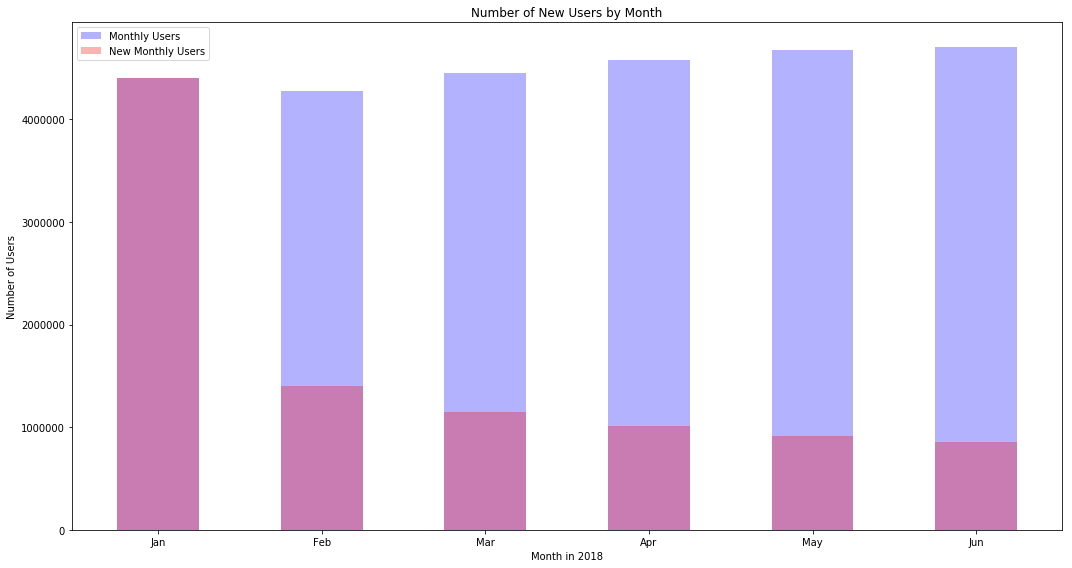

In [12]:
n_months = 6

new_items = (4405371, 1399329, 1147947, 1008304, 915452, 855243)
total_items = (4405371, 4273228, 4448607, 4574164, 4676742, 4709158)

fig, ax = plt.subplots()

index = np.arange(n_months)
bar_width = 0.5

opacity = 0.3

rects1 = ax.bar(index, total_items, bar_width,
                alpha=opacity, color='b',
                label='Monthly Users')

rects2 = ax.bar(index, new_items, bar_width,
                alpha=opacity, color='r',
                label='New Monthly Users')

ax.set_xlabel('Month in 2018')
ax.set_ylabel('Number of Users')
ax.set_title('Number of New Users by Month')
ax.set_xticks(index)
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'))
ax.legend()

fig.tight_layout()
plt.show()

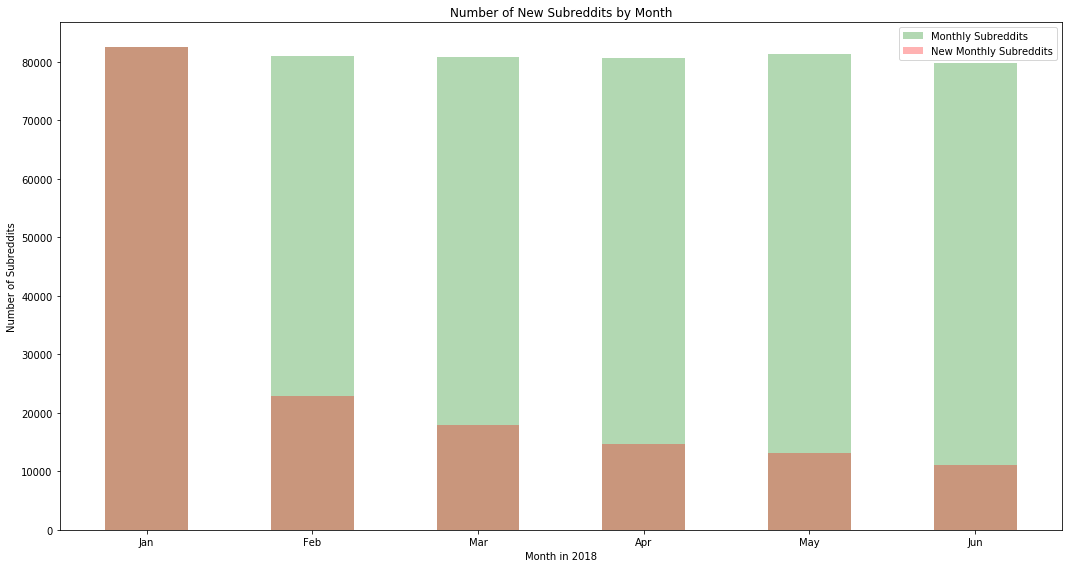

In [59]:
n_months = 6

new_items = (82613, 22799, 17883, 14679, 13170, 11098)
total_items = (82613, 80938, 80791, 80588, 81300, 79823)

fig, ax = plt.subplots()

index = np.arange(n_months)
bar_width = 0.5

opacity = 0.3

rects1 = ax.bar(index, total_items, bar_width,
                alpha=opacity, color='g',
                label='Monthly Subreddits')

rects2 = ax.bar(index, new_items, bar_width,
                alpha=opacity, color='r',
                label='New Monthly Subreddits')

ax.set_xlabel('Month in 2018')
ax.set_ylabel('Number of Subreddits')
ax.set_title('Number of New Subreddits by Month')
ax.set_xticks(index)
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'))
ax.legend()

fig.tight_layout()
plt.show()

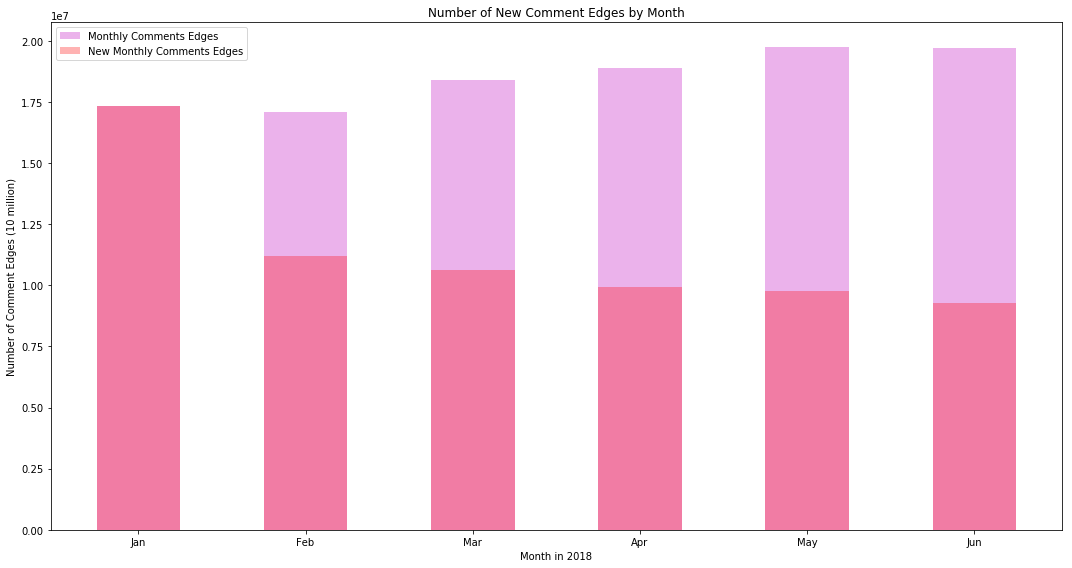

In [60]:
n_months = 6

new_items = (17335250, 11216079, 10607156, 9935803, 9779387, 9264329)
total_items = (17335250, 17096766, 18400751, 18902294, 19765760, 19691982)

fig, ax = plt.subplots()

index = np.arange(n_months)
bar_width = 0.5

opacity = 0.3

rects1 = ax.bar(index, total_items, bar_width,
                alpha=opacity, color='m',
                label='Monthly Comments Edges')

rects2 = ax.bar(index, new_items, bar_width,
                alpha=opacity, color='r',
                label='New Monthly Comments Edges')

ax.set_xlabel('Month in 2018')
ax.set_ylabel('Number of Comment Edges (10 million)')
ax.set_title('Number of New Comment Edges by Month')
ax.set_xticks(index)
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'))
ax.legend()

fig.tight_layout()
plt.show()

### 6-Monthes: Prune Users Who Only Commented on 1 Subreddit 

In [9]:
# filtered_users = set()
# for user, subreddits in user_subreddit_dict.iteritems(): # user -> set(subreddit_ids)
#     if len(subreddits) == 1:
#         filtered_users.add(user)

# print "Number of users who commented on one subreddit: ", len(filtered_users) 

# # Save filtered user to disk
# with open(filtered_users_file, 'w') as outfile:
#     for user in filtered_users:
#         outfile.write("{}\n".format(user))

Number of users who commented on one subreddit:  3805629


### Statistics on Unseen Nodes and Edges

In [11]:
# unseen_users = current_users.difference(users)
# print "CURRENT: Percent of users unseen: %.1f%% = %s / %s" % (100.0 * len(unseen_users) / len(current_users), len(unseen_users), len(current_users))

# unseen_subreddits = current_subreddit_ids.difference(subreddit_ids) 
# print "CURRENT: Percent of subreddits unseen: %.1f%% = %s / %s" % (100.0 * len(unseen_subreddits) / len(current_subreddit_ids), len(unseen_subreddits), len(current_subreddit_ids))

# unseen_comment_edges = current_comment_edges.difference(comment_edges)
# print "CURRENT: Percent of comment edges unseen: %.1f%% = %s / %s" % (100.0 * len(unseen_comment_edges) / len(current_comment_edges), len(unseen_comment_edges), len(current_comment_edges))

CURRENT: Percent of users unseen: 5.4% = 203871 / 3809748
CURRENT: Percent of subreddits unseen: 13.9% = 10784 / 77801
CURRENT: Percent of comment edges unseen: 45.8% = 8612957 / 18792572


In [46]:
def print_subreddit_statistics(comment_weights, comment_edges, users, subreddit_ids, user_subreddit_dict, subreddit_user_dict):
    print "Number of average subreddits per user: ", 1.0 * len(comment_edges) /  len(users)
    total_num_comments = sum(comment_weights.itervalues())
    print "Number of average comments per user: ", 1.0 * total_num_comments /  len(users)

    subreddit_freq_dict = defaultdict(int)
    for user, subreddits in user_subreddit_dict.iteritems():
        subreddit_freq_dict[len(subreddits)] += 1

    max_subreddit_count = 50
    subreddit_counts = np.arange(1, max_subreddit_count)
    num_users = [subreddit_freq_dict[subreddit_count] for subreddit_count in subreddit_counts]
    cum_num_users = [sum(num_users[:subreddit_count+1]) for subreddit_count in subreddit_counts]

    plt.title("Cumulative Number of Users who Commented on N-Subreddits? (Jan-Jun)")
    plt.xlabel("N-Subreddits")
    plt.ylabel("Number of Users")
    plt.plot(subreddit_counts, cum_num_users)
    plt.show()
    
    print "Top-50 user counts: ", num_users[:max_subreddit_count]

    # The slices will be ordered and plotted counter-clockwise.
    labels = [(str(subreddit_count) + " Subreddit(s)") for subreddit_count in subreddit_counts[:15]] + ['16+ Subreddits']# ['Rayos X (88.4 %)', 'RMN en solucion (10.6 %)', 'Microscopia electronica (0.7 %)', 'Otros (0.3 %)']
    sizes = num_users[:15] + [sum(num_users[15:])] # [88.4, 10.6, 0.7, 0.3]
    patches, texts = plt.pie(sizes, startangle=90)
    plt.title("Proportion of Users that Commented on N-Subreddits (Jan-Jun)")
    plt.legend(patches, labels, loc="best")
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    print "Percent of users who comment on just 1 Subreddit: ", 100.0 * sum(num_users[:1]) / len(users)
    print "Percent of users who comment on just 1 or 2 Subreddits: ", 100.0 * sum(num_users[:2]) / len(users)
    print "Percent of users who comment on just 1, 2, or 3 Subreddits: ", 100.0 * sum(num_users[:3]) / len(users)
    print "Percent of users who comment on just 1-10 Subreddits: ", 100.0 * sum(num_users[:10]) / len(users)
    
    user_freq_dict = defaultdict(int)
    for subreddit, users in subreddit_user_dict.iteritems():
        user_freq_dict[len(users)] += 1
    
    max_user_count = 50
    user_counts = np.arange(1, max_user_count)
    num_subreddits = [user_freq_dict[user_count] for user_count in user_counts]
    cum_num_subreddits = [sum(num_subreddits[:user_count+1]) for user_count in user_counts]
    print(num_subreddits)
    print(cum_num_subreddits)
    
    plt.title("Cumulative Number of Subreddits With N-Users? (Jan-Jun)")
    plt.xlabel("N-Users")
    plt.ylabel("Number of Subreddits")
    plt.plot(user_counts, cum_num_subreddits)
    plt.show()
    
    print "Top-30 subreddit counts: ", num_subreddits[:max_user_count]

    # The slices will be ordered and plotted counter-clockwise.
    labels = [(str(user_count) + " User(s)") for user_count in user_counts[:10]] + ['11+ Users']# ['Rayos X (88.4 %)', 'RMN en solucion (10.6 %)', 'Microscopia electronica (0.7 %)', 'Otros (0.3 %)']
    sizes = num_subreddits[:10] + [sum(num_subreddits[10:])] # [88.4, 10.6, 0.7, 0.3]
#     colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
    patches, texts = plt.pie(sizes, startangle=90)
    plt.title("Proportion of Subreddits That Had N-Users (Jan-Jun)")
    plt.legend(patches, labels, loc="best")
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
    print "Percent of subreddits with 1 User: ", 100.0 * sum(num_subreddits[:1]) / len(subreddit_ids)
    print "Percent of subreddits with 1 or 2 Users: ", 100.0 * sum(num_subreddits[:2]) / len(subreddit_ids)
    print "Percent of subreddits with 1, 2, or 3 users: ", 100.0 * sum(num_subreddits[:3]) / len(subreddit_ids)
    print "Percent of subreddits with 1-5 users: ", 100.0 * sum(num_subreddits[:5]) / len(subreddit_ids)
    

Number of average subreddits per user:  7.00169364977
Number of average comments per user:  54.6048630417


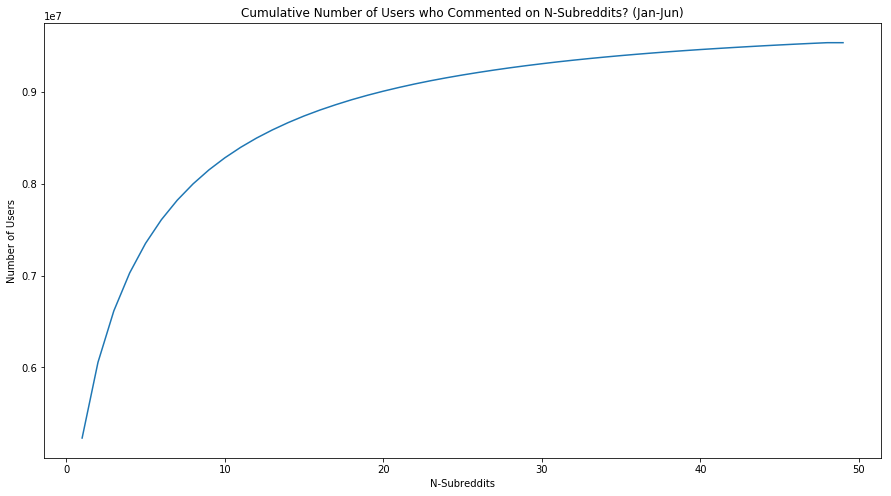

Top-50 user counts:  [3805629, 1426432, 823628, 560116, 413352, 321449, 257569, 212212, 177927, 152244, 130944, 114424, 100623, 88878, 79852, 71946, 64487, 58307, 53819, 48725, 44576, 40999, 38102, 35119, 32148, 29948, 27785, 26146, 24434, 22783, 21258, 20256, 18671, 17562, 16487, 15700, 14598, 13864, 13196, 12309, 11755, 10828, 10526, 10005, 9663, 9057, 8698, 8136, 7751]


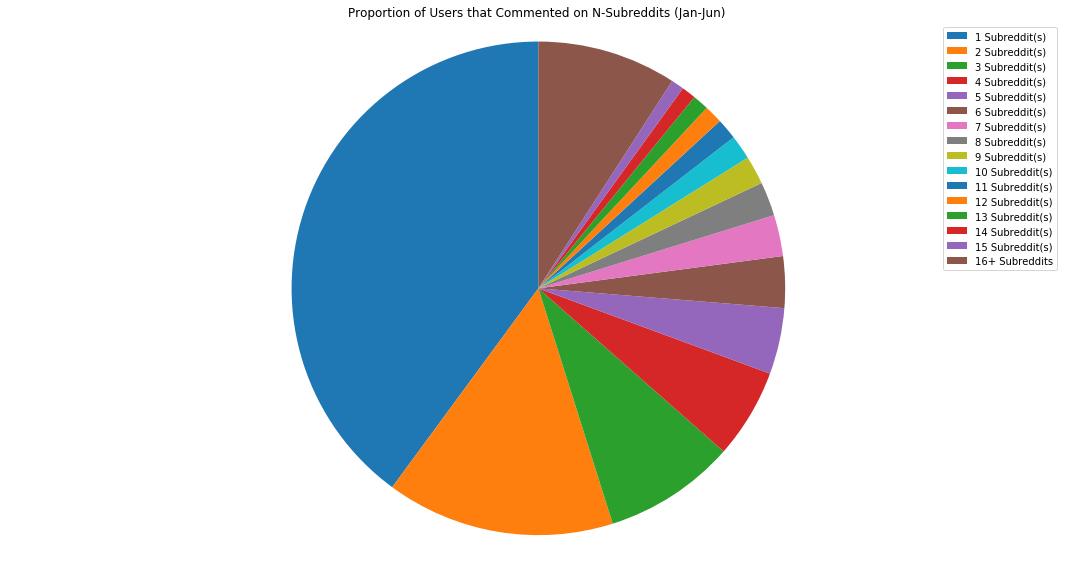

Percent of users who comment on just 1 Subreddit:  39.1057072976
Percent of users who comment on just 1 or 2 Subreddits:  53.7633715817
Percent of users who comment on just 1, 2, or 3 Subreddits:  62.2267702709
Percent of users who comment on just 1-10 Subreddits:  83.7531287102
[39395, 23387, 12619, 8410, 5929, 4657, 3711, 3070, 2601, 2184, 1965, 1755, 1579, 1401, 1295, 1227, 1136, 1001, 924, 841, 822, 759, 727, 697, 648, 676, 596, 531, 537, 502, 482, 471, 454, 418, 403, 402, 391, 372, 367, 344, 351, 342, 301, 306, 300, 287, 275, 258, 270]
[62782, 75401, 83811, 89740, 94397, 98108, 101178, 103779, 105963, 107928, 109683, 111262, 112663, 113958, 115185, 116321, 117322, 118246, 119087, 119909, 120668, 121395, 122092, 122740, 123416, 124012, 124543, 125080, 125582, 126064, 126535, 126989, 127407, 127810, 128212, 128603, 128975, 129342, 129686, 130037, 130379, 130680, 130986, 131286, 131573, 131848, 132106, 132376, 132376]


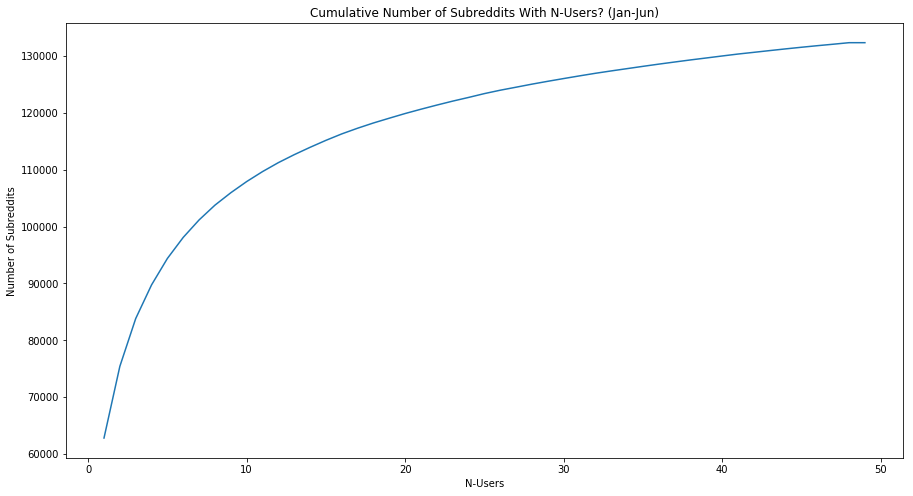

Top-30 subreddit counts:  [39395, 23387, 12619, 8410, 5929, 4657, 3711, 3070, 2601, 2184, 1965, 1755, 1579, 1401, 1295, 1227, 1136, 1001, 924, 841, 822, 759, 727, 697, 648, 676, 596, 531, 537, 502, 482, 471, 454, 418, 403, 402, 391, 372, 367, 344, 351, 342, 301, 306, 300, 287, 275, 258, 270]


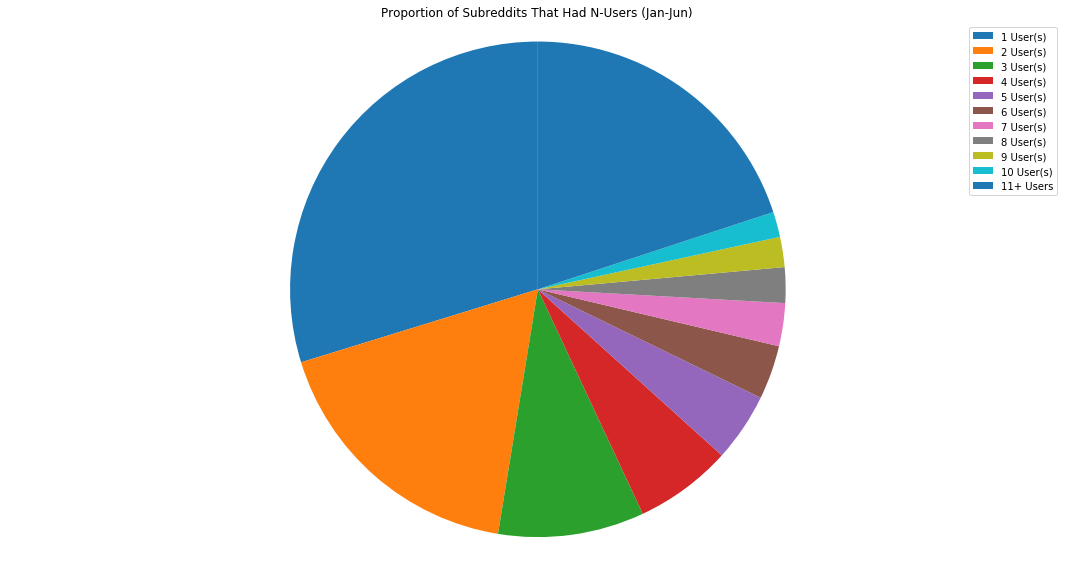

Percent of subreddits with 1 User:  24.2816286781
Percent of subreddits with 1 or 2 Users:  38.6965150824
Percent of subreddits with 1, 2, or 3 users:  46.4744024359
Percent of subreddits with 1-5 users:  55.3124345114


In [47]:
print_subreddit_statistics(comment_weights, comment_edges, users, subreddit_ids, user_subreddit_dict, subreddit_user_dict)

Number of average subreddits per user:  7.00169364977
Number of average comments per user:  54.6048630417


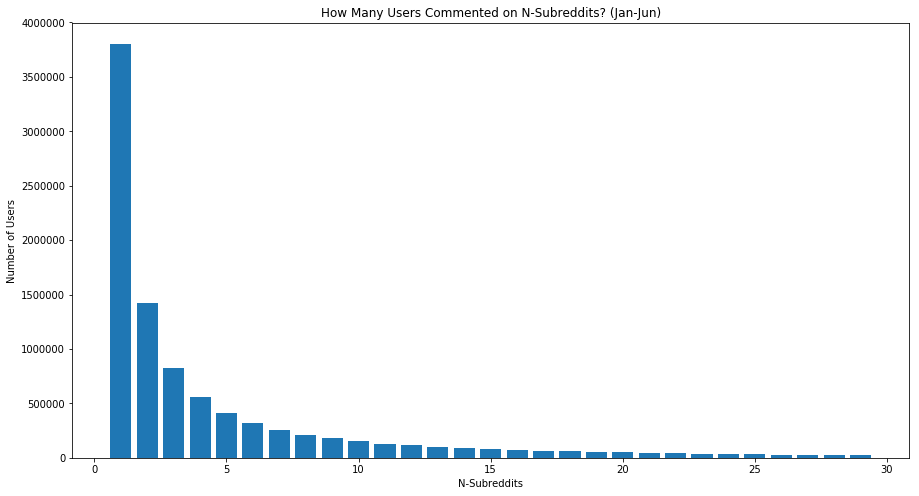

Top-30 user counts:  [3805629, 1426432, 823628, 560116, 413352, 321449, 257569, 212212, 177927, 152244, 130944, 114424, 100623, 88878, 79852, 71946, 64487, 58307, 53819, 48725, 44576, 40999, 38102, 35119, 32148, 29948, 27785, 26146, 24434]


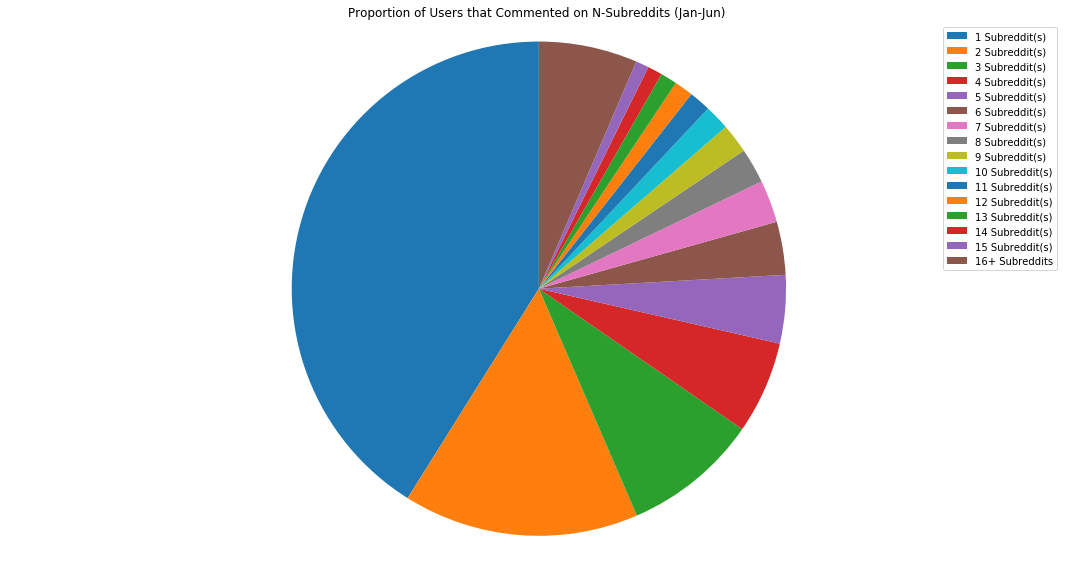

Percent of users who comment on just 1 Subreddit:  39.1057072976
Percent of users who comment on just 1 or 2 Subreddits:  53.7633715817
Percent of users who comment on just 1, 2, or 3 Subreddits:  62.2267702709
Percent of users who comment on just 1-10 Subreddits:  83.7531287102


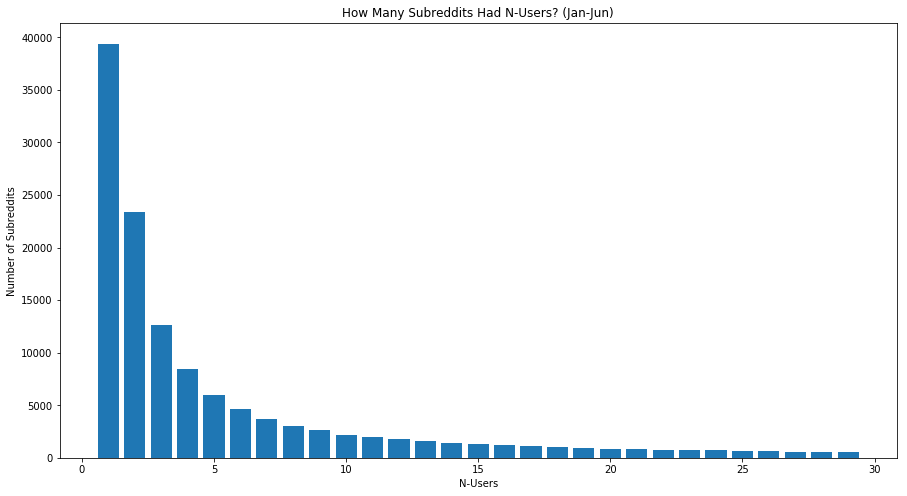

Top-30 subreddit counts:  [39395, 23387, 12619, 8410, 5929, 4657, 3711, 3070, 2601, 2184, 1965, 1755, 1579, 1401, 1295, 1227, 1136, 1001, 924, 841, 822, 759, 727, 697, 648, 676, 596, 531, 537]


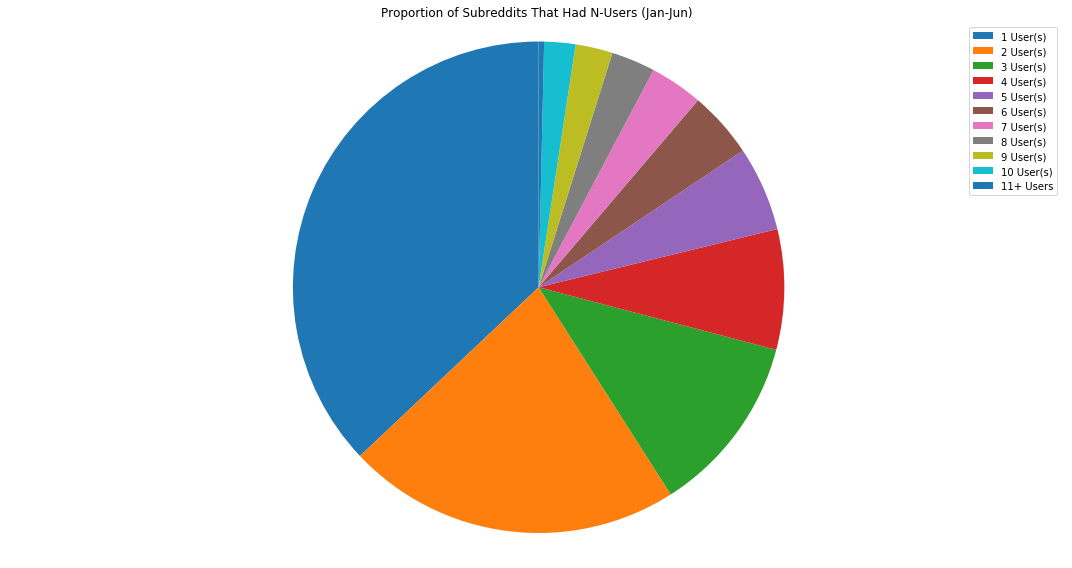

Percent of subreddits with 1 User:  24.2816286781
Percent of subreddits with 1 or 2 Users:  38.6965150824
Percent of subreddits with 1, 2, or 3 users:  46.4744024359
Percent of subreddits with 1-10 users:  65.3116948756


In [150]:
print_subreddit_statistics(comment_weights, comment_edges, users, subreddit_ids, user_subreddit_dict, subreddit_user_dict)

In [10]:
##############################################
# Construct Node and Edge IDs
##############################################
def generate_node_ids(alls_users, all_subreddit_ids):
    """
    Generate node ids by assigning each user a consecutive
    integer value in [0, num_users) and each subreddit
    a consecutive integer value in [num_users, num_users+num_subreddits)

    Returns dictionaries of users and subreddit_ids to their corresponding
    node ids.
    """
    num_users = len(alls_users) # = MAX_UID
    num_subreddits = len(all_subreddit_ids)

    # Iterate through sorted users
    user_node_ids = {} # user -> user_node_id
    users = sorted(alls_users)
    for user_node_id, user in enumerate(users):
        user_node_ids[user] = user_node_id

    # Iterate through sorted subreddit ids
    subreddit_node_ids = {} # subreddit_id -> subreddit_node_id
    subreddit_ids = sorted(all_subreddit_ids)
    for subreddit_node_id, subreddit_id in enumerate(subreddit_ids):
        subreddit_node_ids[subreddit_id] = num_users + subreddit_node_id # shifted by num_users

    return user_node_ids, subreddit_node_ids

In [11]:
user_node_ids, subreddit_node_ids = generate_node_ids(users, subreddit_ids)

In [12]:
# Save
np.save(user_node_ids_file, user_node_ids) 
np.save(subreddit_node_ids_file, subreddit_node_ids) 

## Construct Bipartite User-Subreddit Graph (with Snap)

In [62]:
def construct_comment_graph(users, subreddit_ids, comment_edges, 
                            all_user_node_ids, all_subreddit_node_ids):
    """
    Creates a the User-Subreddit bipartite undirected graph where the nodes
    are users and subreddits and the edges between the users and subreddits
    represent when a user has commented on a subreddit.
    """
    # Construct the bipartise graph
    C = snap.PUNGraph.New()

    # Add user node ids
    for user in users:
        user_node_id = all_user_node_ids[user]
        C.AddNode(user_node_id)
        
    print "Done adding user nodes."

    # Add subreddit node ids
    for subreddit_id in subreddit_ids:
        subreddit_node_id = all_subreddit_node_ids[subreddit_id]
        C.AddNode(subreddit_node_id)
    
    print "Done adding subreddit nodes."
        
    # Add comment edges
    for i, comment_edge in enumerate(comment_edges):
        user, subreddit_id = comment_edge
        user_node_id = all_user_node_ids[user]
        subreddit_node_id = all_subreddit_node_ids[subreddit_id]
        C.AddEdge(user_node_id, subreddit_node_id)
        
        if i % 1000000 == 0:
            print "Processed %s / %s edges" % (i , len(comment_edges))

    print "Done adding comment edges."

    return C

In [ ]:
C = construct_comment_graph(users, subreddit_ids, comment_edges, all_user_node_ids, all_subreddit_node_ids)

print "C: Number of nodes: ", C.GetNodes()
print "C: Number of edges: ", C.GetEdges()

Done adding user nodes.
Done adding subreddit nodes.
Processed 0 / 58873675 edges
Processed 1000000 / 58873675 edges
Processed 2000000 / 58873675 edges
Processed 3000000 / 58873675 edges
Processed 4000000 / 58873675 edges
Processed 5000000 / 58873675 edges
Processed 6000000 / 58873675 edges


In [ ]:
snap.SaveEdgeList(C, comment_graph_file) # save graph to text file

In [63]:
C_current = construct_comment_graph(current_users, current_subreddit_ids, current_comment_edges, all_user_node_ids, all_subreddit_node_ids)

Done adding user nodes.
Done adding subreddit nodes.
Processed 0 / 19691982 edges
Processed 1000000 / 19691982 edges
Processed 2000000 / 19691982 edges
Processed 3000000 / 19691982 edges
Processed 4000000 / 19691982 edges
Processed 5000000 / 19691982 edges
Processed 6000000 / 19691982 edges
Processed 7000000 / 19691982 edges
Processed 8000000 / 19691982 edges
Processed 9000000 / 19691982 edges
Processed 10000000 / 19691982 edges
Processed 11000000 / 19691982 edges
Processed 12000000 / 19691982 edges
Processed 13000000 / 19691982 edges
Processed 14000000 / 19691982 edges
Processed 15000000 / 19691982 edges
Processed 16000000 / 19691982 edges
Processed 17000000 / 19691982 edges
Processed 18000000 / 19691982 edges
Processed 19000000 / 19691982 edges
Done adding comment edges.
C_current: Number of nodes: 

NameError: name 'C' is not defined

In [65]:
print "C_current: Number of nodes: ", C_current.GetNodes()
print "C_current: Number of edges: ", C_current.GetEdges()

C_current: Number of nodes:  4788981
C_current: Number of edges:  19691982


In [68]:
snap.SaveEdgeList(C_current, current_comment_graph_file) # save graph to text file

## Print Basic Statistics about Graph

In [ ]:
# G_cluster_coeff = snap.GetClustCf(G, 1000)
# G_density = float(G.GetEdges()) / (G.GetNodes() * (G.GetNodes() - 1))

# print "Clustering Coefficient: ", G_cluster_coeff
# print "Density: ", G_density

## Plot Degree Distribution Graph

In [22]:
def getFilteredDataPointsToPlot(Graph, filtered_nodes):
    """
    :param - Graph: snap.PUNGraph object representing an undirected graph
    :filtered_nodes - list: list of Node IDs that we want to plot

    return values:
    X: list of degrees
    Y: list of frequencies: Y[i] = fraction of nodes with degree X[i]
    """
    N = len(filtered_nodes) # total number of nodes in graph

    # Get frequency counts of degree
    degreeFreq = {}
    for node_id in filtered_nodes:
        node = G.GetNI(node_id)
        degree = node.GetOutDeg()
        if degree in degreeFreq:
            degreeFreq[degree] += 1
        else:
            degreeFreq[degree] = 1

    X, Y = [], []
    for degree, count in degreeFreq.iteritems():
        count_ratio = float(count) / N
        X.append(degree)
        Y.append(count_ratio)
    return X, Y

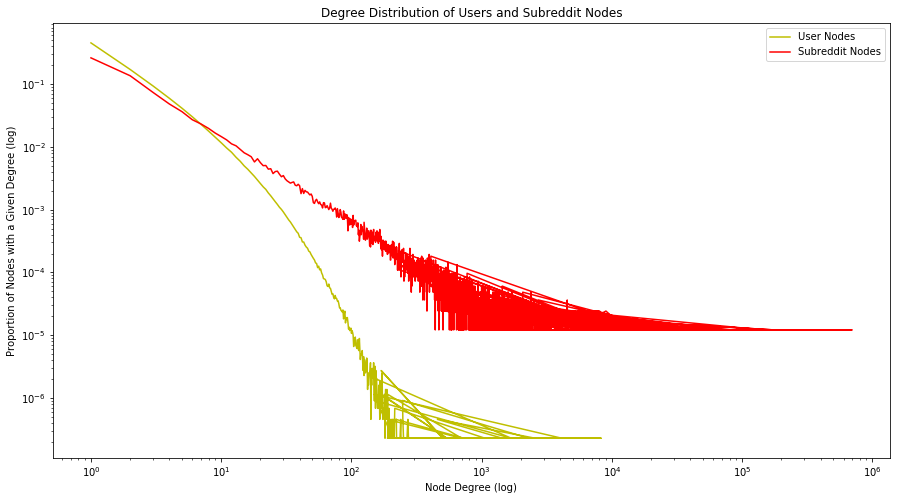

In [21]:
x_user, y_user = getFilteredDataPointsToPlot(G, filtered_nodes=user_node_ids.values())
plt.loglog(x_user, y_user, color = 'y', label = 'User Nodes')

x_subreddit, y_subreddit = getFilteredDataPointsToPlot(G, filtered_nodes=subreddit_node_ids.values())
plt.loglog(x_subreddit, y_subreddit, color = 'r', label = 'Subreddit Nodes')

plt.xlabel('Node Degree (log)')
plt.ylabel('Proportion of Nodes with a Given Degree (log)')
plt.title('Degree Distribution of Users and Subreddit Nodes')
plt.legend()
plt.show()

## Construct User-User Graph (Shared Subreddits)

In [27]:
def construct_user_graph(G, user_node_ids, subreddit_node_ids):
    U = snap.PUNGraph.New()

    # Add user node ids
    for user, user_node_id in user_node_ids.iteritems():
        U.AddNode(user_node_id)

    # Add edges between users
    for subreddit_id, subreddit_node_id in subreddit_node_ids.iteritems():
        node = G.GetNI(subreddit_node_id)

        # Collect all subreddit neighbor nodes
        user_nodes = []
        for user_id in node.GetOutEdges():
            user_nodes.append(user_id)

        # At least two users share this subreddit
        if len(user_nodes) >= 2:
            user_pairs = list(itertools.combinations(user_nodes, 2))
            for firstNode, secondNode in user_pairs:
                U.AddEdge(firstNode, secondNode)
    
    return U

In [ ]:
U = construct_user_graph(G, user_node_ids, subreddit_node_ids)

In [ ]:
print "U: Number of nodes: ", U.GetNodes()
print "U: Number of edges: ", U.GetEdges()

U_cluster_coeff = snap.GetClustCf(U, 100)
print "U: Clustering Coefficient: ", U_cluster_coeff